In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

import warnings
warnings.filterwarnings("ignore")

#맥북 한글
from matplotlib import rc
rc('font', family ='AppleGothic')

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mat

# (1) 설치된 폰트 출력
import matplotlib.font_manager as fonm
font_list = [font.name for font in fonm.fontManager.ttflist]
for f in font_list:
    print(f"{f}.ttf")
mat.rcParams['font.family'] = 'Malgun Gothic'

## 따릉이 데이터 전처리 수행

### 결측치 처리

In [176]:
train_data = pd.read_csv('../DATA/train.csv',encoding='cp949')
test_data = pd.read_csv('../DATA/test.csv',encoding='cp949')


In [177]:
train_data.rename(columns={'Date':'날짜', 'Rented Bike Count':'대여횟수', 'Hour':'시', 'Temperature(吏퇒)':'온도', 'Humidity(%)':'습도',
       'Wind speed (m/s)':'풍속', 'Visibility (10m)':'가시성', 'Dew point temperature(吏퇒)':'이슬점',
       'Solar Radiation (MJ/m2)':'태양 복사에너지', 'Rainfall(mm)':'강수량', 'Snowfall (cm)':'강설량', 'Seasons':'계절',
       'Holiday':'휴무일여부', 'Functioning Day':'작동여부'}, inplace=True)
train_data['날짜']=pd.to_datetime(train_data['날짜'], format='%d/%m/%Y')

test_data.rename(columns={'Date':'날짜', 'Rented Bike Count':'대여횟수', 'Hour':'시', 'Temperature(吏퇒)':'온도', 'Humidity(%)':'습도',
       'Wind speed (m/s)':'풍속', 'Visibility (10m)':'가시성', 'Dew point temperature(吏퇒)':'이슬점',
       'Solar Radiation (MJ/m2)':'태양 복사에너지', 'Rainfall(mm)':'강수량', 'Snowfall (cm)':'강설량', 'Seasons':'계절',
       'Holiday':'휴무일여부', 'Functioning Day':'작동여부'}, inplace=True)
test_data['날짜']=pd.to_datetime(test_data['날짜'], format='%d/%m/%Y')


In [178]:
train_data.isnull().sum()
test_data.isnull().sum()

날짜            0
대여횟수          0
시             0
온도          800
습도            0
풍속          802
가시성           0
이슬점           0
태양 복사에너지      0
강수량           0
강설량           0
계절          802
휴무일여부         0
작동여부          0
dtype: int64

날짜           0
시            0
온도          76
습도           0
풍속          74
가시성          0
이슬점          0
태양 복사에너지     0
강수량          0
강설량          0
계절          74
휴무일여부        0
작동여부         0
dtype: int64

In [179]:
# 계절 전처리 
# 1. date 타입으로 날짜 형식 변환
train_data['날짜']=pd.to_datetime(train_data['날짜'], format='%d/%m/%Y')

# 2. 입춘 입하 입추 입동 기준으로 처리
# 날짜 구간 나누기
winter_df= (train_data['날짜'] >= '2017-11-07') & (train_data['날짜'] < '2018-02-04')
spring_df = (train_data['날짜'] >= '2018-02-04') & (train_data['날짜'] < '2018-05-05')
summer_df = (train_data['날짜'] >= '2018-05-05') & (train_data['날짜'] < '2018-08-07')
autumn_df = (train_data['날짜'] >= '2018-08-07') & (train_data['날짜'] < '2018-11-07')

# 조건문으로 빈 값 채우기
if (winter_df).any():
    train_data['계절'].fillna('Winter', inplace=True)
elif (spring_df).any():
    train_data['계절'].fillna('Spring', inplace=True)
elif (summer_df).any():
    train_data['계절'].fillna('Summer', inplace=True)
elif (autumn_df).any():
    train_data['계절'].fillna('Autumn', inplace=True)

In [180]:
# 계절 전처리 
# 1. date 타입으로 날짜 형식 변환
test_data['날짜']=pd.to_datetime(test_data['날짜'], format='%d/%m/%Y')

# 2. 입춘 입하 입추 입동 기준으로 처리
# 날짜 구간 나누기
spring_df = (test_data['날짜'] >= '2018-02-04') & (test_data['날짜'] < '2018-05-05')
summer_df = (test_data['날짜'] >= '2018-05-05') & (test_data['날짜'] < '2018-08-07')
autumn_df = (train_data['날짜'] >= '2018-08-07') & (train_data['날짜'] < '2018-11-07')
winter_df= (test_data['날짜'] >= '2018-11-07') & (test_data['날짜'] < '2019-02-04')

# 조건문으로 빈 값 채우기
if (winter_df).any():
    test_data['계절'].fillna('Winter', inplace=True)
elif (spring_df).any():
    test_data['계절'].fillna('Spring', inplace=True)
elif (summer_df).any():
    test_data['계절'].fillna('Summer', inplace=True)
elif (autumn_df).any():
    test_data['계절'].fillna('Autumn', inplace=True)

In [181]:
tem_season_df=pd.DataFrame(train_data.groupby(['계절'])['온도'].mean())
x=tem_season_df.values.flatten().tolist()
if (train_data['계절']=='Autumn').any():
    train_data['온도'].fillna(round(x[0],2), inplace=True)
elif (train_data['계절']=='Spring').any():
    train_data['온도'].fillna(round(x[1],2), inplace=True)
elif (train_data['계절']=='Summer').any():
    train_data['온도'].fillna(round(x[2],2), inplace=True)
elif (train_data['계절']=='Winter').any():
    train_data['온도'].fillna(round(x[3],2), inplace=True)

In [182]:
# 온도 결측치 처리
# 계절 평균온도로 결측치 처리해주기 
df_tem=test_data.copy()
tem_season_df=pd.DataFrame(test_data.groupby(['계절'])['온도'].mean())
x=tem_season_df.values.flatten().tolist()
if (test_data['계절']=='Autumn').any():
    df_tem['온도'].fillna(round(x[0],2), inplace=True)
elif (test_data['계절']=='Spring').any():
    df_tem['온도'].fillna(round(x[1],2), inplace=True)
elif (test_data['계절']=='Summer').any():
    df_tem['온도'].fillna(round(x[2],2), inplace=True)
elif (test_data['계절']=='Winter').any():
    df_tem['온도'].fillna(round(x[3],2), inplace=True)

In [183]:
from fancyimpute import IterativeImputer
df_num=train_data._get_numeric_data()
imputer = IterativeImputer()
imputed_arr=imputer.fit_transform(train_data[['풍속', '태양 복사에너지', '시','습도']])
train_data.풍속=pd.DataFrame(imputed_arr, columns=['풍속', '태양 복사에너지', '시','습도']).풍속

In [184]:
# 풍속 결측치 처리
imputer = IterativeImputer()
imputed_arr=imputer.fit_transform(test_data[['풍속', '태양 복사에너지', '시','습도']])
df_tem.풍속=pd.DataFrame(imputed_arr, columns=['풍속', '태양 복사에너지', '시','습도']).풍속

In [185]:
train_data.isnull().sum()


날짜          0
대여횟수        0
시           0
온도          0
습도          0
풍속          0
가시성         0
이슬점         0
태양 복사에너지    0
강수량         0
강설량         0
계절          0
휴무일여부       0
작동여부        0
dtype: int64

In [186]:
df_tem.isnull().sum()
test_data=df_tem

날짜          0
시           0
온도          0
습도          0
풍속          0
가시성         0
이슬점         0
태양 복사에너지    0
강수량         0
강설량         0
계절          0
휴무일여부       0
작동여부        0
dtype: int64

### 이상치 처리

In [187]:
train_data.shape

(8040, 14)

In [188]:
# 작동하지 않은 날에 대여횟수가 No이기 때문에 대여횟수 0인 것은 선형 회귀 모델에 있어서 의미 있는 데이터가 아니다.
# 그러므로 삭제하는 것이 좋음
train_data= train_data.drop(train_data[train_data['대여횟수']==0].index,axis=0)

In [189]:
train_data.shape

(7817, 14)

### 범주형 데이터 처리

In [190]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
result_ohe = ohe.fit_transform(train_data[["계절","휴무일여부","작동여부"]])
result_ohe

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.]])

In [191]:
ohe_2 = OneHotEncoder(sparse_output=False)
result_ohe_2 = ohe_2.fit_transform(test_data[["계절","휴무일여부","작동여부"]])
result_ohe_2

array([[1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       ...,
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.]])

In [192]:
#각 변수들의 카테고리가 학습된 것을 확인
ohe.categories_
ohe_2.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object),
 array(['Yes'], dtype=object)]

[array(['Autumn', 'Winter'], dtype=object),
 array(['No Holiday'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [193]:
df_ohe = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(["계절","휴무일여부","작동여부"]))
df_ohe_2 = pd.DataFrame(result_ohe_2, columns=ohe_2.get_feature_names_out(["계절","휴무일여부","작동여부"]))

df_ohe
df_ohe_2

,계절_Autumn,계절_Spring,계절_Summer,계절_Winter,휴무일여부_Holiday,휴무일여부_No Holiday,작동여부_Yes
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
7812,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7813,0.0,0.0,0.0,1.0,0.0,1.0,1.0
7814,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7815,1.0,0.0,0.0,0.0,0.0,1.0,1.0


,계절_Autumn,계절_Winter,휴무일여부_No Holiday,작동여부_No,작동여부_Yes
0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...
715,0.0,1.0,1.0,0.0,1.0
716,1.0,0.0,1.0,0.0,1.0
717,1.0,0.0,1.0,0.0,1.0
718,1.0,0.0,1.0,0.0,1.0


In [194]:
x_df = train_data.select_dtypes(include=['object']).columns
new_df_ = train_data.drop(columns=x_df)
train_data = pd.concat([df_ohe, new_df_.reset_index()], axis=1)


In [195]:
y_df = test_data.select_dtypes(include=['object']).columns
new_df_2_ = test_data.drop(columns=y_df)
test_data = pd.concat([df_ohe_2, new_df_2_.reset_index()], axis=1)


In [312]:
train_data.info()
test_data.info()
train= train_data.copy()
test = test_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   계절_Autumn         7817 non-null   float64       
 1   계절_Spring         7817 non-null   float64       
 2   계절_Summer         7817 non-null   float64       
 3   계절_Winter         7817 non-null   float64       
 4   휴무일여부_Holiday     7817 non-null   float64       
 5   휴무일여부_No Holiday  7817 non-null   float64       
 6   작동여부_Yes          7817 non-null   float64       
 7   index             7817 non-null   int64         
 8   날짜                7817 non-null   datetime64[ns]
 9   대여횟수              7817 non-null   int64         
 10  시                 7817 non-null   int64         
 11  온도                7817 non-null   float64       
 12  습도                7817 non-null   int64         
 13  풍속                7817 non-null   float64       
 14  가시성               7817 n

In [197]:
arr1=train.columns
arr2=test.columns

In [198]:
intersection = set(arr1) & set(arr2)

print("중복되는 값들:", intersection)

중복되는 값들: {'날짜', '계절_Autumn', '이슬점', '온도', 'index', '강설량', '습도', '작동여부_Yes', '휴무일여부_No Holiday', '시', '태양 복사에너지', '계절_Winter', '풍속', '강수량', '가시성'}


In [25]:
# '강설량', '풍속', '습도','날짜', '가시성', '계절_Winter', '강수량', '이슬점', '온도', '태양 복사에너지', '계절_Autumn', '시'

### 최종 변수

#### 대여횟수에 영향을 미치는 피처 확인

<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='시', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='온도', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='습도', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='풍속', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='가시성', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='이슬점', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='태양 복사에너지', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='강수량', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='강설량', ylabel='대여횟수'>

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

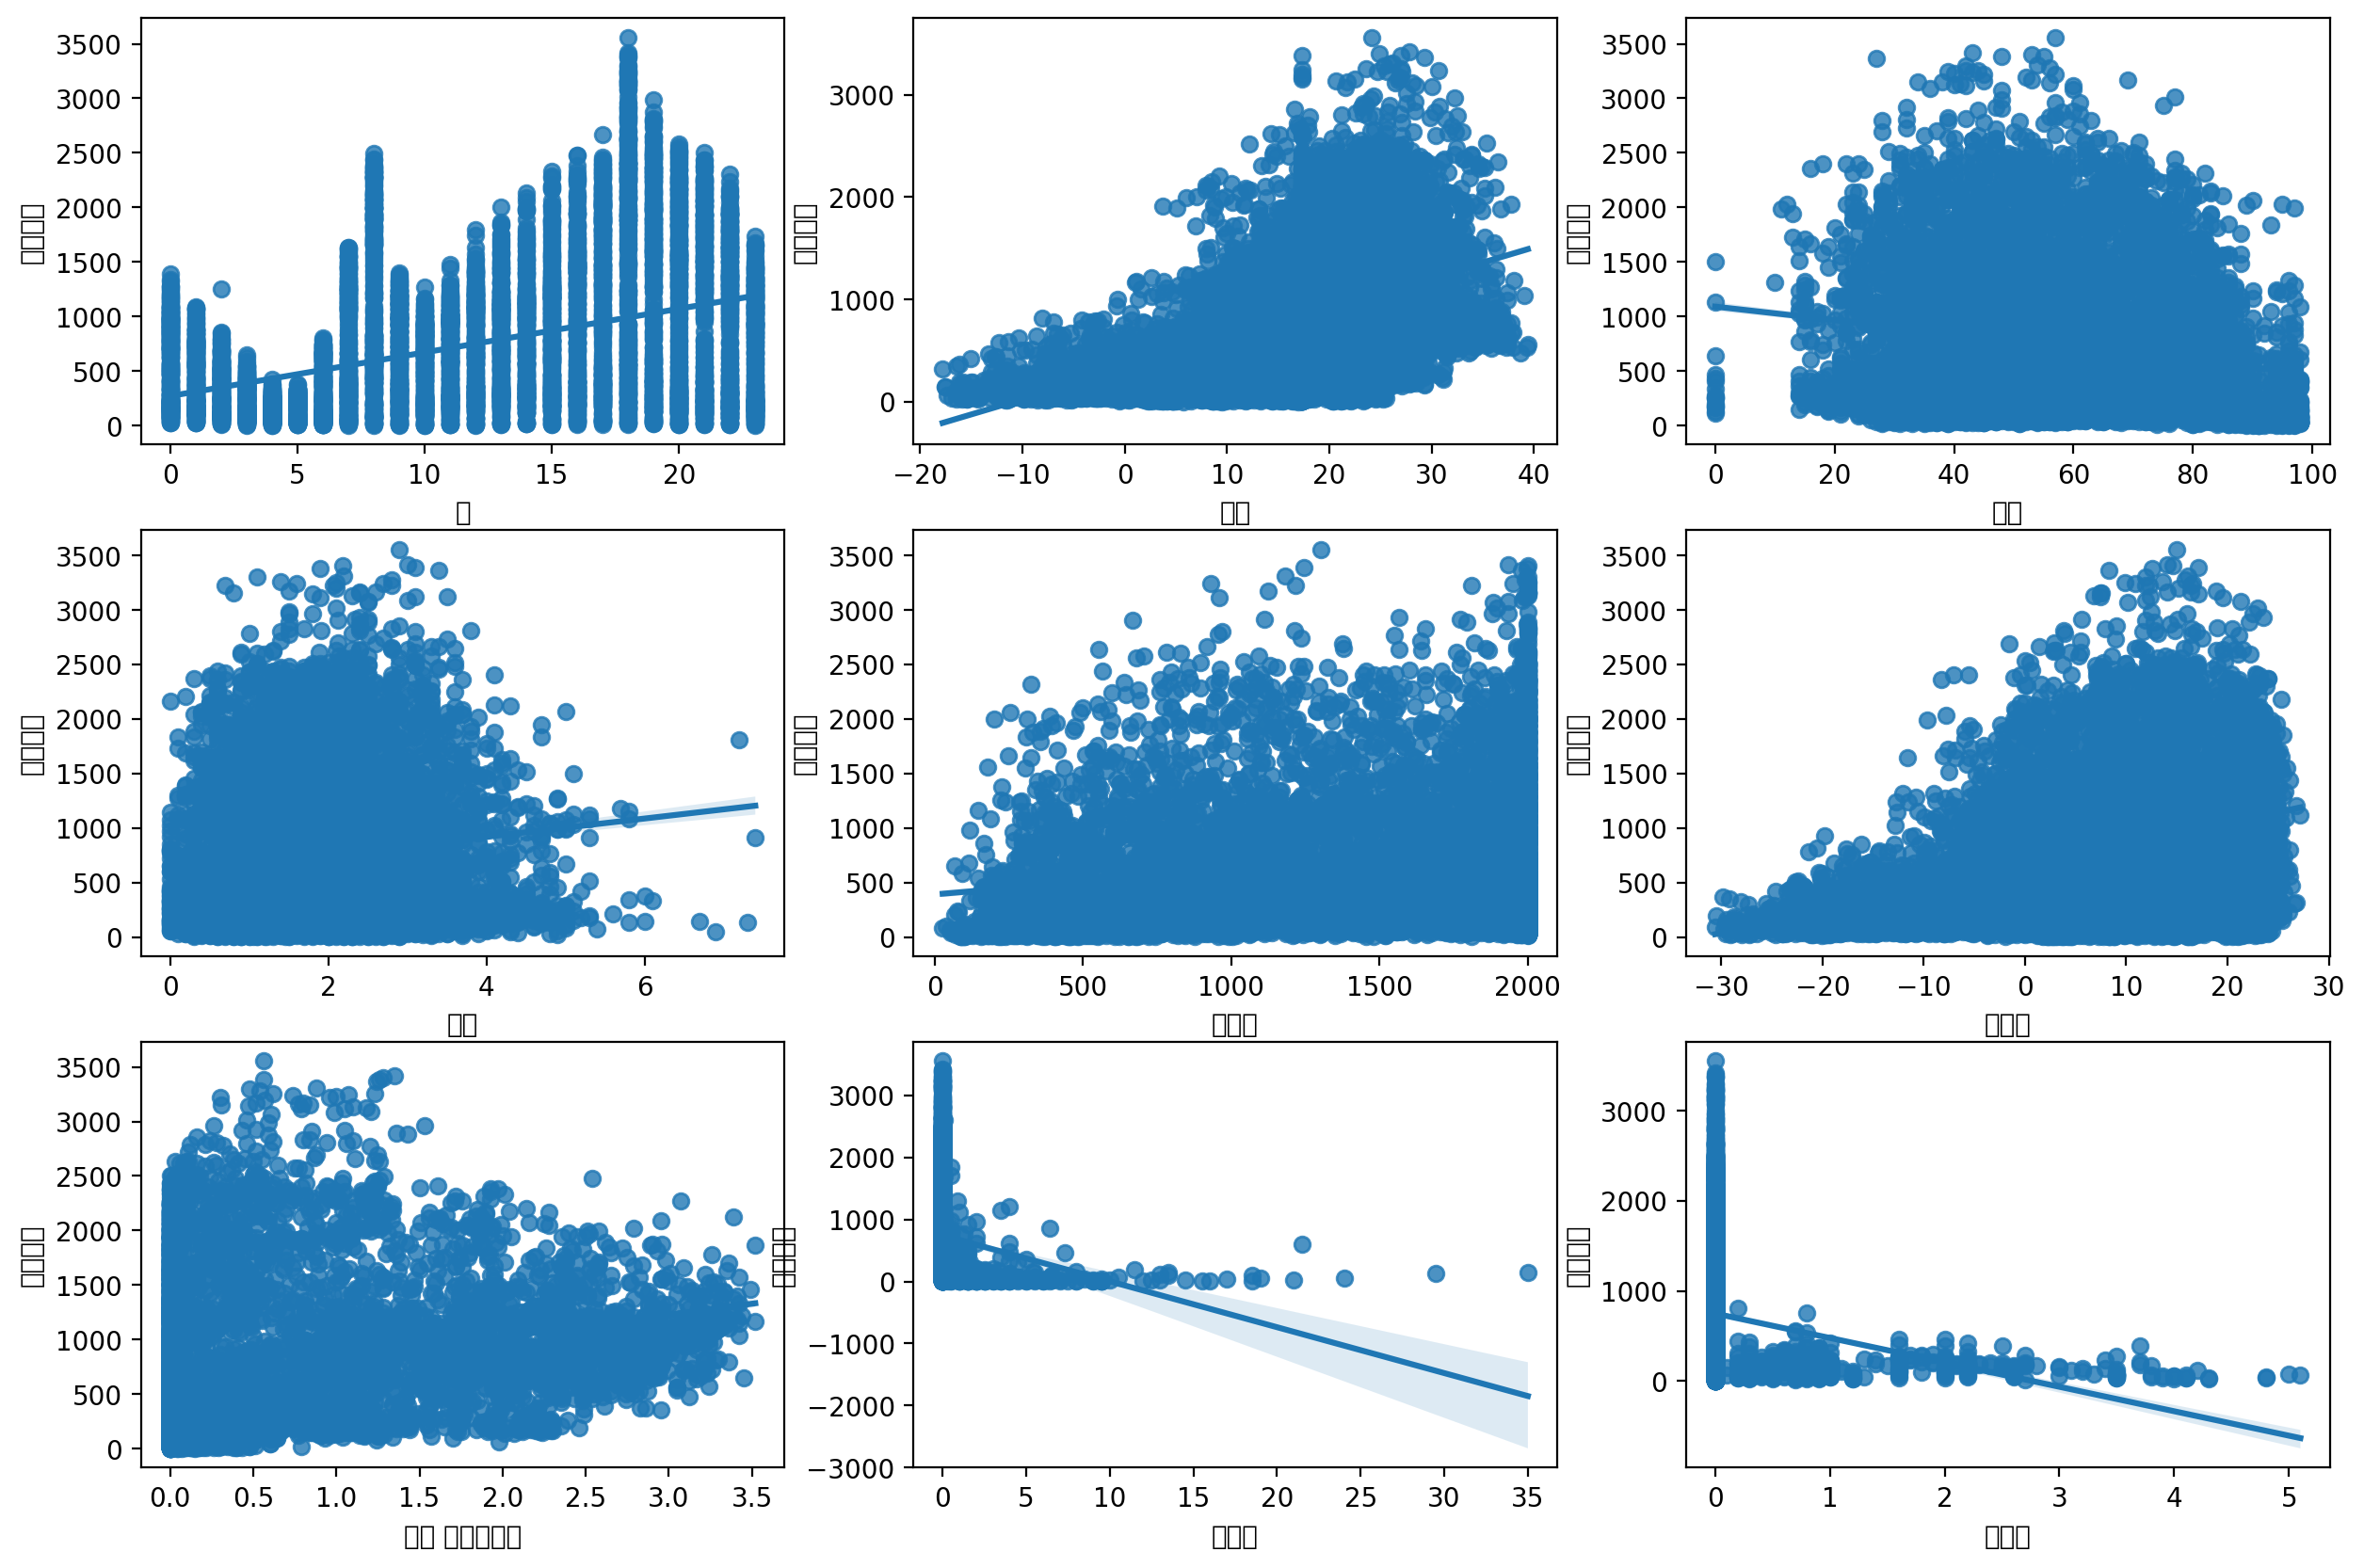

In [26]:
features= ['시','온도','습도','풍속','가시성','이슬점','태양 복사에너지','강수량','강설량']
plt.figure(figsize=(15,10))
for i , features in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.regplot(x=features, y='대여횟수', data=train_data)
    
plt.show()

In [313]:
#필요없는 열은 제거(범주형 모두 삭제)
train_b=train.drop(["index","휴무일여부_No Holiday","작동여부_Yes","날짜","계절_Autumn","계절_Spring","계절_Summer","계절_Winter","휴무일여부_Holiday"], axis=1, inplace = False)

test_b=test.drop(["index","휴무일여부_No Holiday","날짜","작동여부_Yes",'작동여부_No',"계절_Autumn","계절_Winter"], axis=1, inplace = False)

In [314]:
# #필요없는 열은 제거(범주형 중복되는것만 남겨놓은 경우) 
train_a=train.drop(["index","날짜","휴무일여부_No Holiday","작동여부_Yes","계절_Spring","계절_Summer","휴무일여부_Holiday"], axis=1, inplace = False)

test_a=test.drop(["index","날짜","휴무일여부_No Holiday","작동여부_Yes",'작동여부_No'], axis=1, inplace = False)

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='대여횟수', ylabel='Count'>

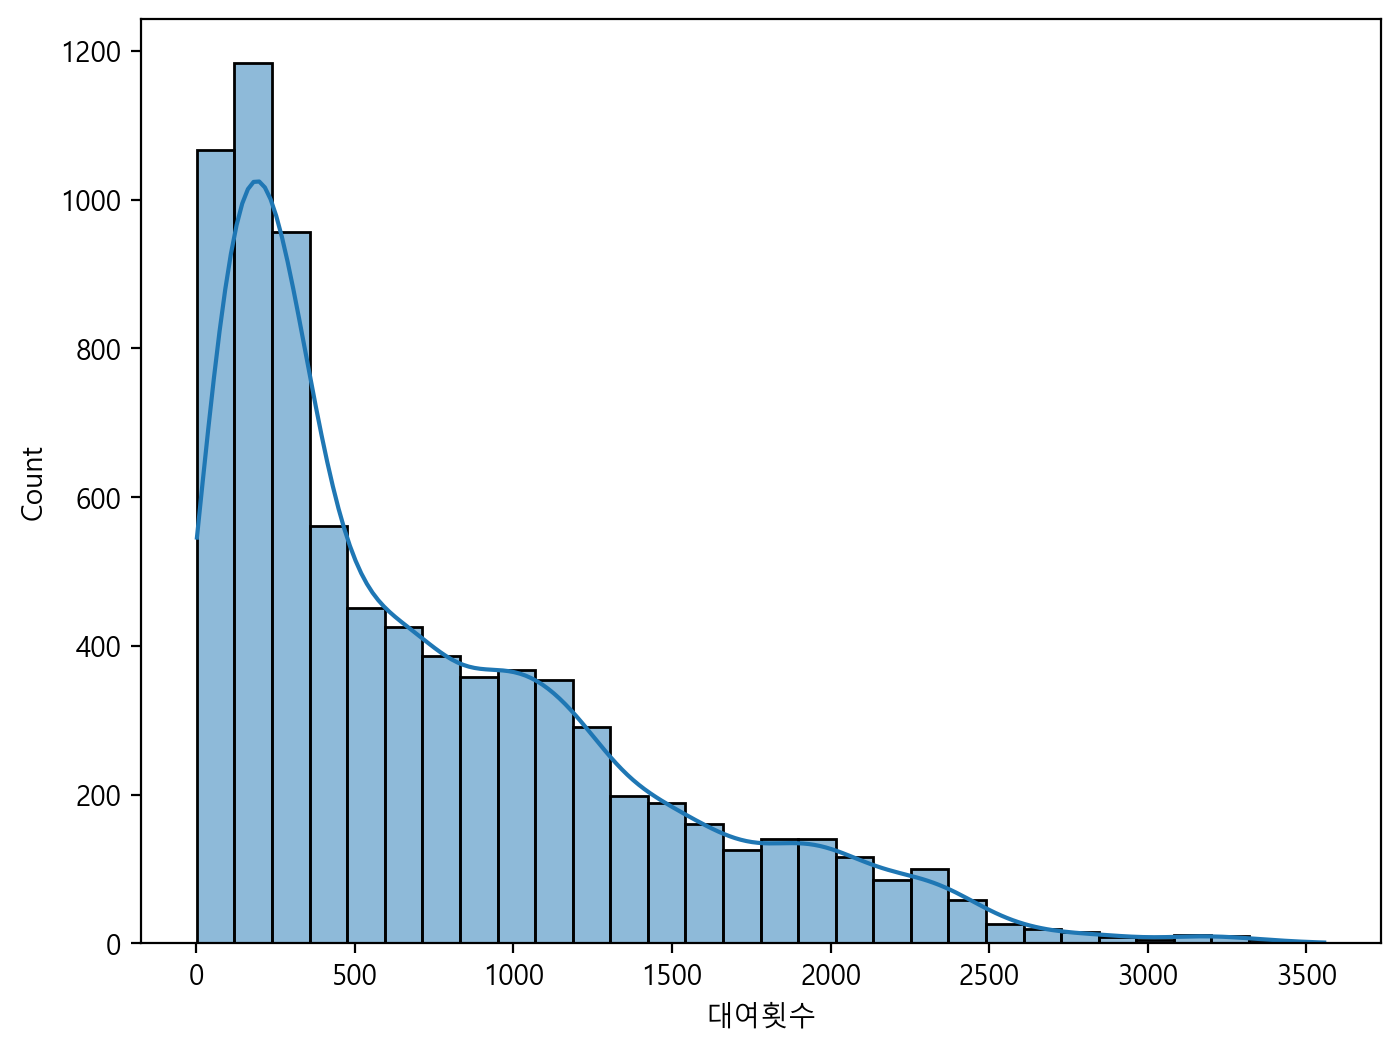

In [315]:
# 타깃 값의 분포 확인 
plt.figure(figsize=(8, 6))
sns.histplot(train_a['대여횟수'], kde=True, bins=30)

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='대여횟수', ylabel='Count'>

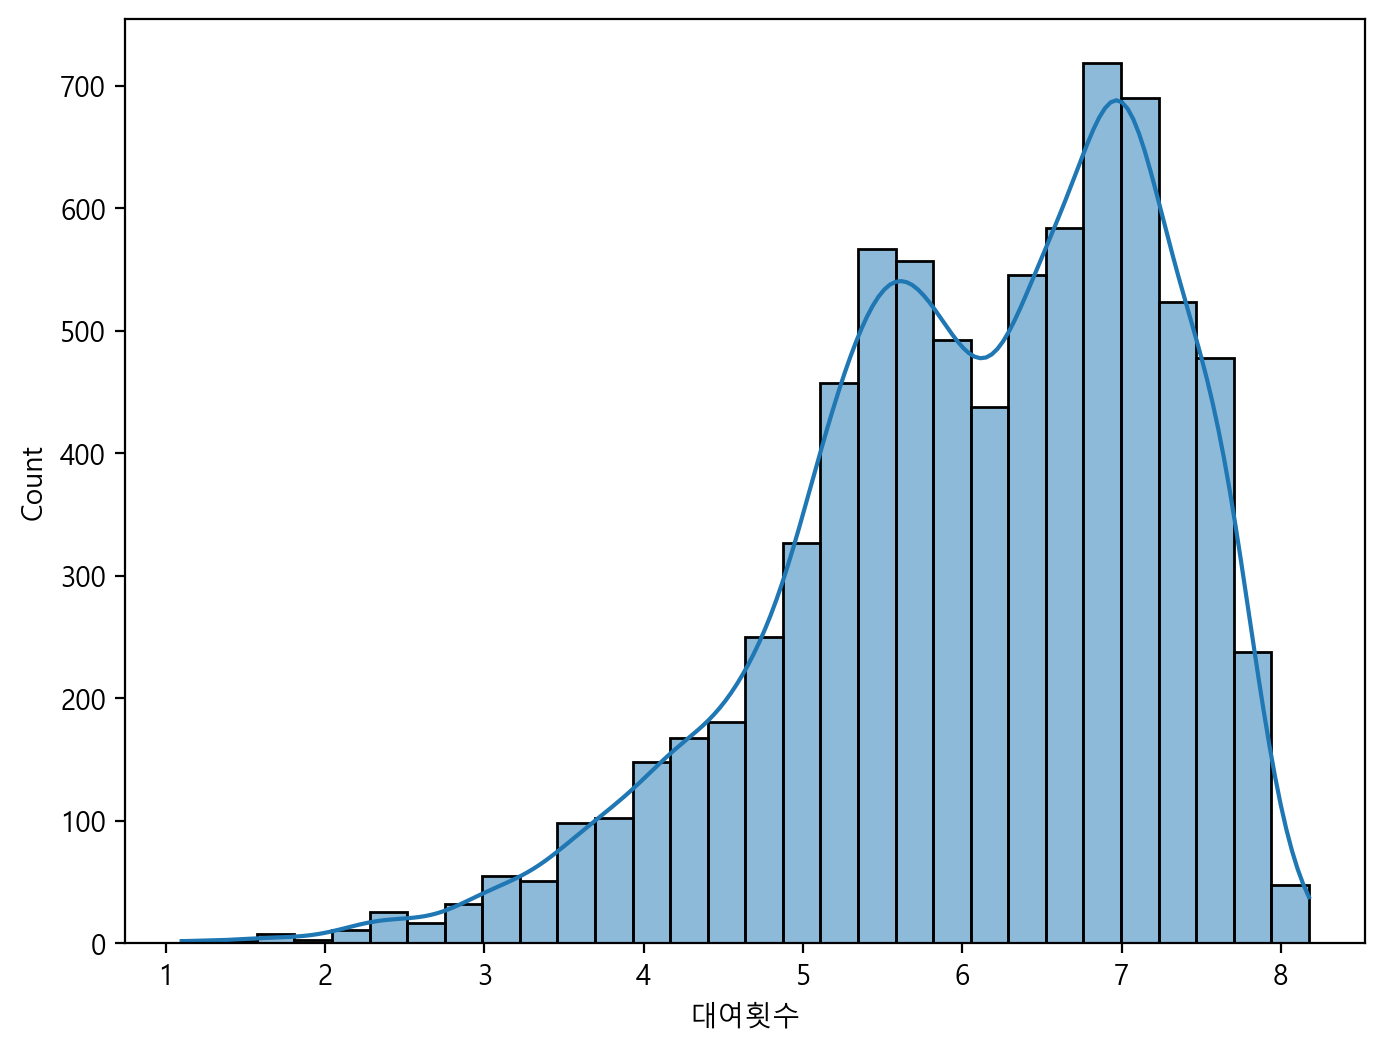

In [316]:
# target값을 로그 변환 후 분포 확인 
lent_log = np.log1p(train_a['대여횟수'])
plt.figure(figsize=(8, 6))
sns.histplot(lent_log, kde=True, bins=30)

In [317]:
train_a['대여횟수']= np.log1p(train_a['대여횟수'])

In [318]:
# TARGET
y_target = train_a['대여횟수']

# X_data
X_data= train_a.drop('대여횟수', axis=1 , inplace=False)

In [319]:
X_test = test_a.copy()

In [320]:
X_test.shape

(720, 11)

In [336]:
# train_a

## 모델 결정

### 대여횟수를 target 값으로 잡고 수치를 예측하는 것이므로 회귀모델이 적절하다고 판단됨 
- 기본 선형회귀 모델 :  linearregression 
- L2 규제 - ridge
- L1 규제 - lasso

#### 규제
- 비용함수에 alpha 값으로 패널티를 부여해서
- 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- L2 방식과 L1 방식

L2 규제
- 회귀 계수 값의 제곱에 대해 패널티를 부여하는 방식
- 회귀 계수의 크기 감소 
- L2 규제를 적용한 회귀 : 릿지(Redge) 방식
    
L1 규제
- 회귀 계수의 절대값에 대해 패널티를 부여하는 방식
- 영향력이 크지 않은 회귀 계수를 0으로 변환하고 제거  
  - 적절한 피처만 회귀에 포함시키는 피처 선택의 특성     
- L1 규제를 적용한 회귀 : 라쏘(Lasso) 회귀  

In [321]:
from sklearn.metrics import mean_squared_error, r2_score

# 평가 함수 작성

# 학습된 모델을 받아서 예측하고 RMSE 반환

# (1) 단일 모델의 RMSE 값 반환
def get_rmse(model):
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse =  np.sqrt(mse)
    
    print("{0} RMSE : {1:.3f}".format(model.__class__.__name__, rmse))
    print('R제곱 : {0:.3f}'.format(r2_score(y_val, y_pred)))
    
    return rmse


# (2) 여러 모델의 RMSE 값 반환 : 1번 함수 호출
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model) # 단일 모델의 RMSE 값 반환하는 함수 호출
        rmses.append(rmse)
    
    return rmses

In [322]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data ,
                                                       y_target ,
                                                       test_size=0.3, 
                                                       random_state=156)

In [323]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 선형 계열의 회귀 모델 생성 및 학습
# LinearRegression / Ridge / Lasso

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge = Ridge()
ridge.fit(X_train, y_train)

lasso = Lasso()
lasso.fit(X_train, y_train)

LinearRegression()

Ridge()

Lasso()

In [324]:
# 평가 함수 호출 / 결과 출력 
get_rmses([lr_reg, ridge, lasso])

LinearRegression RMSE : 0.734
R제곱 : 0.600
Ridge RMSE : 0.734
R제곱 : 0.600
Lasso RMSE : 0.797
R제곱 : 0.528


[0.7336509650660138, 0.7336474340040553, 0.7968719362314357]

In [325]:
# linear과 ridge 는 서로 성능이 비슷하고 lasso는 성능이 한참 떨어짐 
# --> 추후 하이퍼 파라미터 튜닝을 진행해서 확인 필요
# --> 최적의 하이퍼 파라미터 찾고
# --> 릿지와 라쏘 모델에 대해 수행

### 모델 별 회귀 계수 시각화

In [326]:
# 피처 수가 많으므로 회귀 계수 값의
# 상위 10개, 하위 10개의 피처명과 회귀 계수값을 반환하는 함수 작성
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체 생성 (회귀 계수와 피처명)
    # index는 피처명(컬럼명)
    coef = pd.Series(model.coef_, index=X_data.columns)
    
    # + 상위 10개, - 하위 10개 회귀 계수 추출하여 반환
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [327]:
# 모델별 회귀 계수 시각화하는 함수
# list 객체로 모델을 입력받은 후
# 가로 막대 그래프 형태 출력

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

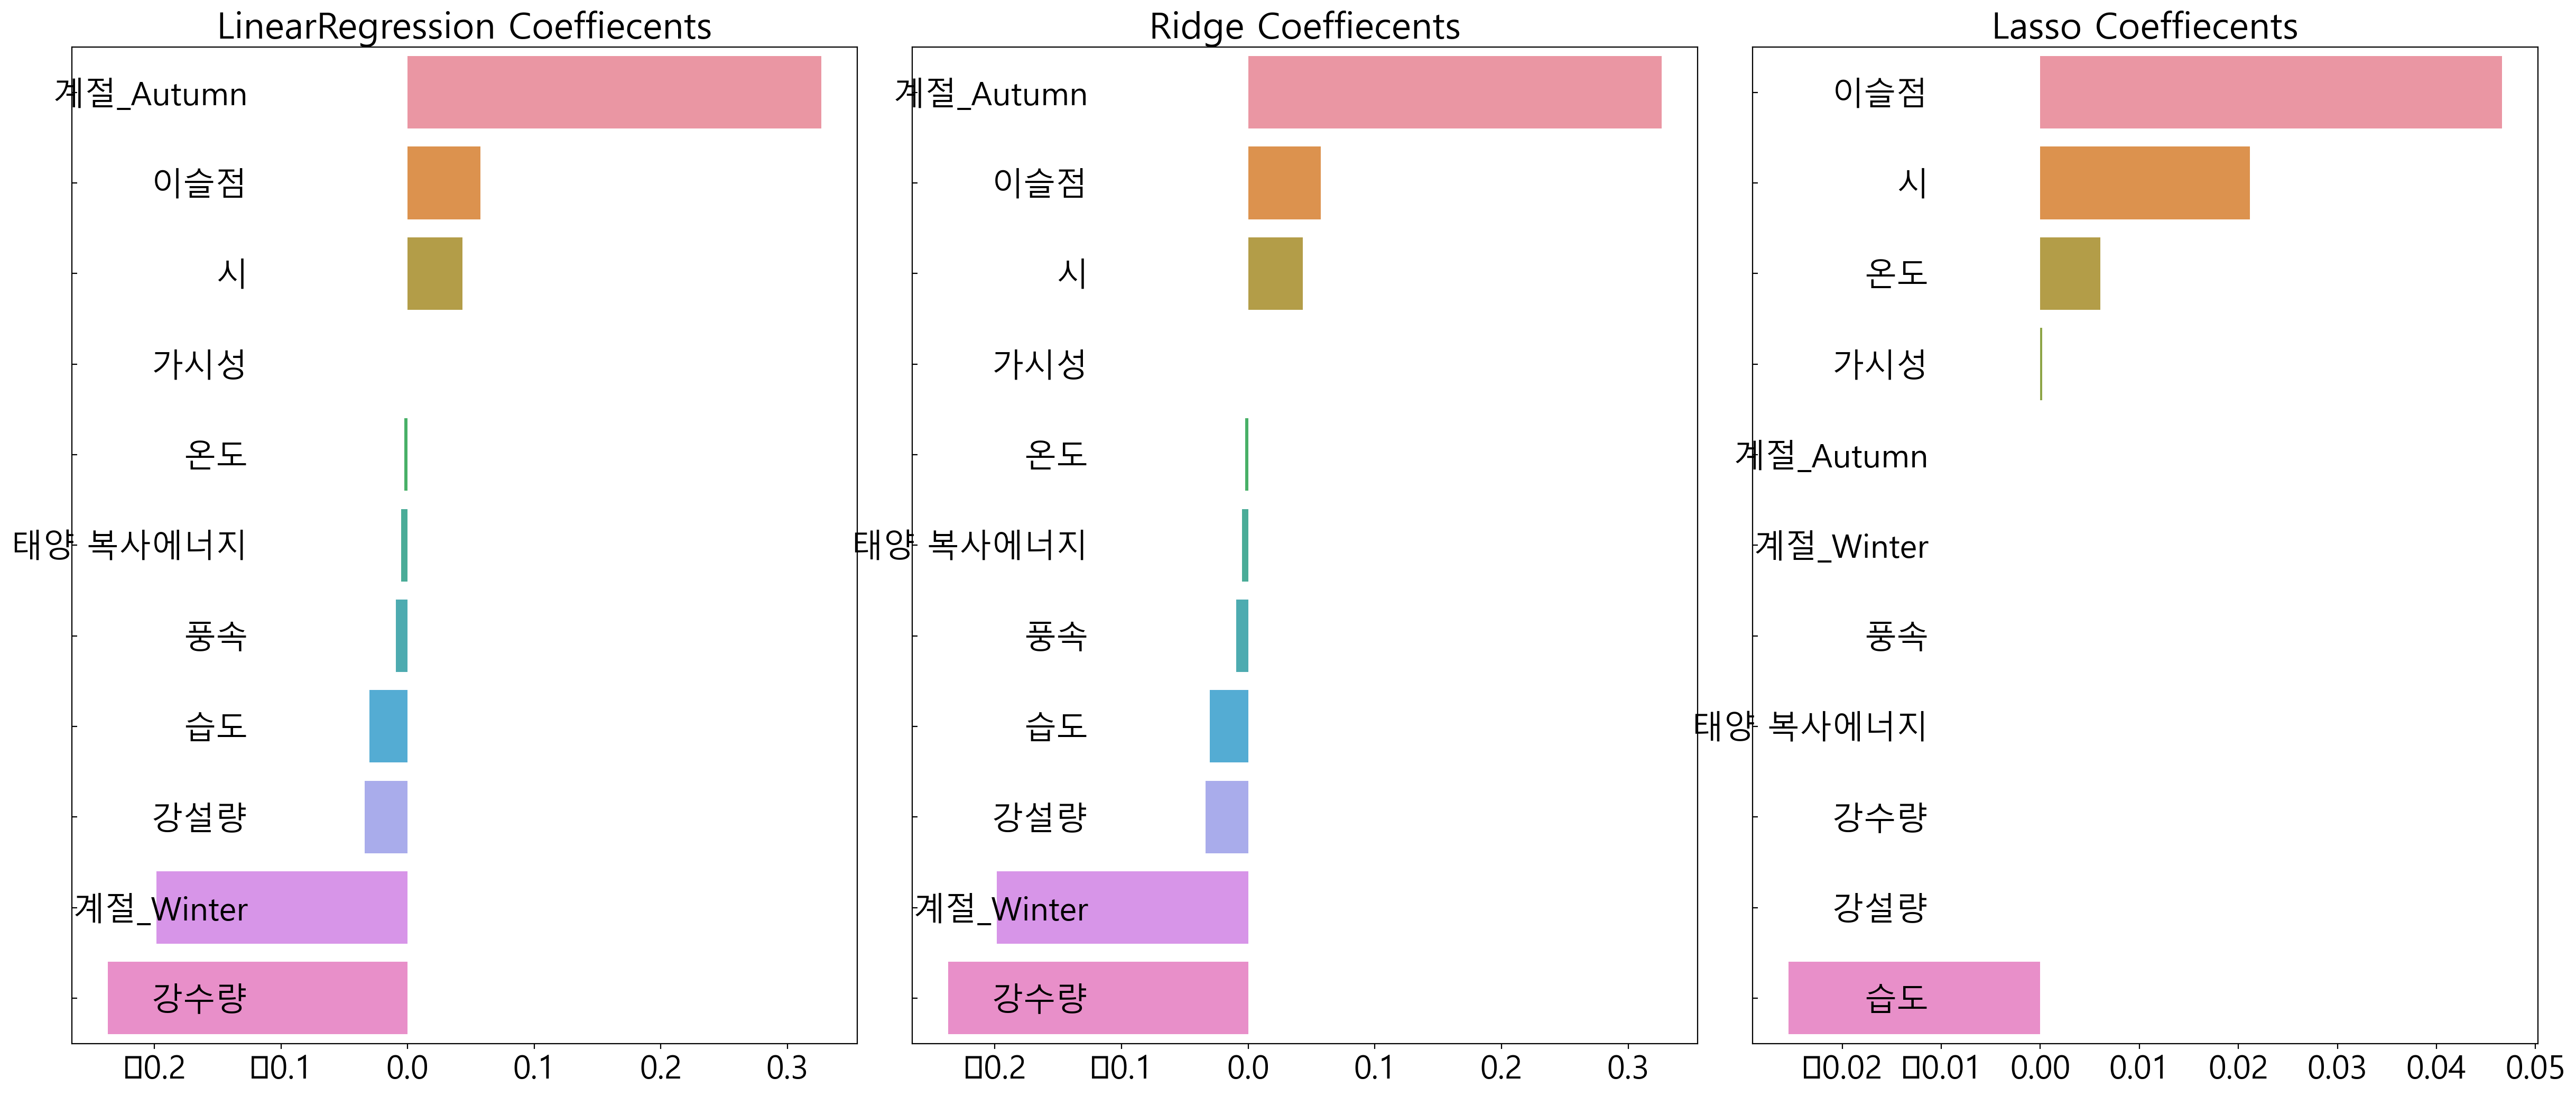

In [328]:
visualize_coefficient([lr_reg, ridge, lasso])
# LinearRegression과 Ridge : 피처 종류와 회귀 계수가 유사한 형태로 분포
# Lasso : 전체적으로 피처 종류도 차이가 있고, 회귀 계수 값이 매우 작음 
# -> 교차검증을 진행하여 평균 RMSE를 확인 필요

In [329]:
from sklearn.model_selection import cross_val_score

# 5개 폴드 교차검증으로 모델별 RMSE와 평균 RNSE 출력

# 교차검증 수행하는 함수 작성
def rmse_avvg_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_data, y_target, 
                                             scoring='neg_mean_squared_error',
                                             cv=5))
        rmse_avg = np.mean(rmse_list)
        print("{0} 교차검증 RMSE : {1}".format(model.__class__.__name__, rmse_list))
        print("{0} 교차검증 평균 RMSE : {1:.3f}".format(model.__class__.__name__, rmse_avg))
    
    
# 함수 호출하고 회귀 모델 전달해서 결과 출력 
rmse_avvg_cv([lr_reg, ridge, lasso])

# 라소의 경우 LinearRegression과 Ridge 모델 보다 성능이 약간 떨어짐
# --> 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키면서 최적값 도출해서 확인 


LinearRegression 교차검증 RMSE : [0.6374987  0.76578131 0.88273208 0.80821313 0.7875857 ]
LinearRegression 교차검증 평균 RMSE : 0.776
Ridge 교차검증 RMSE : [0.63745122 0.7657883  0.88269703 0.80826617 0.78760594]
Ridge 교차검증 평균 RMSE : 0.776
Lasso 교차검증 RMSE : [0.77657713 0.86236582 0.93943834 0.82892231 0.88124572]
Lasso 교차검증 평균 RMSE : 0.858


In [330]:
# 릿지와 라쏘 모델의 alpha 값을 변화시키면서 하이퍼 파라미터 튜닝 수행 

from sklearn.model_selection import GridSearchCV

# 튜닝 수행 함수 작성
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error',
                             cv=5)
    grid_model.fit(X_data, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
     # 최적 평균 RMSE 값 출력 , 최적 alpha 값 
    print("{0} 최적 평균 RMSE : {1:.4f}, 최적 alpha {2} ".format(model.__class__.__name__, 
                                                                rmse,
                                                                grid_model.best_params_))   
    return grid_model.best_estimator_

# ridge_params : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] 
# lasso_params: [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]

ridge_params = {'alpha' : [0,0.0000000001,0.00001,0.001,0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = {'alpha' : [0.001, 0.0001, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

best_ridge = get_best_params(ridge, ridge_params)
best_lasso = get_best_params(lasso, lasso_params)    

Ridge 최적 평균 RMSE : 0.7805, 최적 alpha {'alpha': 0} 
Lasso 최적 평균 RMSE : 0.7800, 최적 alpha {'alpha': 0.001} 


### 최적의 alpha 값으로 학습 예측 평가

Ridge(alpha=0)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.734
R제곱 : 0.600
Ridge RMSE : 0.734
R제곱 : 0.600
Lasso RMSE : 0.734
R제곱 : 0.600


[0.7336509650660138, 0.7336509650660137, 0.7336603039479325]

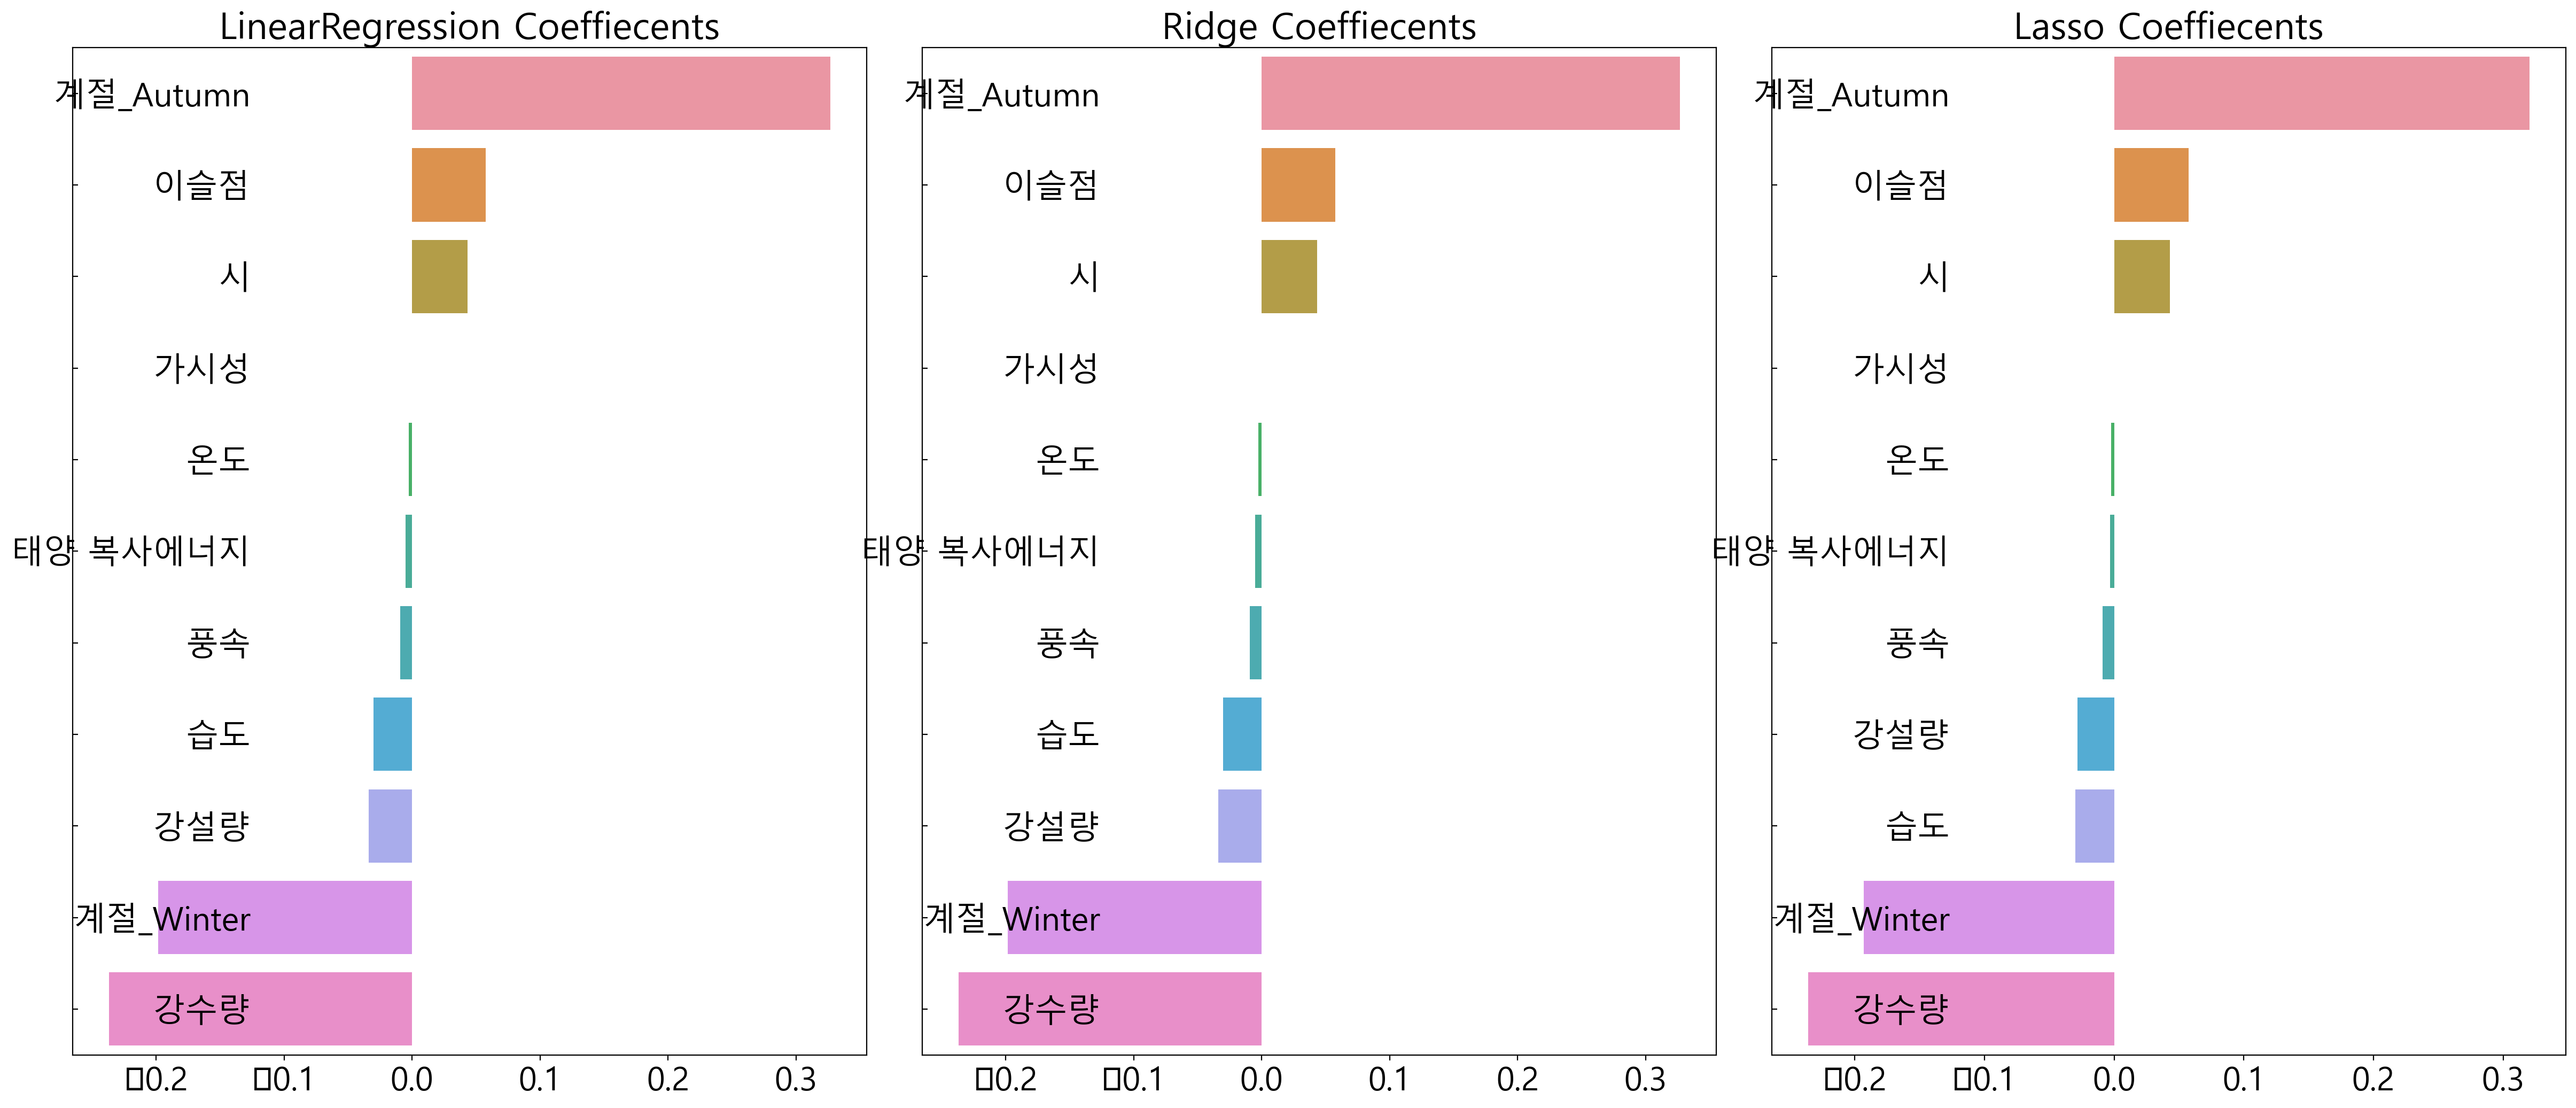

In [331]:
ridge = Ridge(alpha=0)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])

In [332]:
### 릿지 라쏘 모두 linearregression 모델에 수렴할 때가 가장 성능이 좋음 
# 피처를 만져봤자 더 향상될거 같지 않지만 한 번 해봄 

### 피처 데이터 로그 변환 및 왜곡도 확인

In [333]:
from scipy.stats import skew

# object가 아닌 숫자형 피처 index 추출
features_index = train_b.dtypes[train_b.dtypes != 'object'].index

# skew() 적용
# apply lambda로 skew() 호출
skew_features = train_b[features_index].apply(lambda x : skew(x))

# skew 정도가 1.15 보다 큰 피처들만 추출 : 대여횟수 skew가 1.15
skew_features_top = skew_features[skew_features > 1.15]
skew_features_top.sort_values(ascending=False)

강수량         14.634243
강설량          7.317045
태양 복사에너지     1.475115
dtype: float64

In [337]:
train_x=train_a.copy()

In [338]:
# 왜곡도가 높은 피처들을 로그 변환
# skew 정도가 1이상인 피처들

train_x[skew_features_top.index] = np.log1p(train_x[skew_features_top.index])
train_x[skew_features_top.index]

,태양 복사에너지,강수량,강설량
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
7812,0.0,0.0,0.0
7813,0.0,0.0,0.0
7814,0.0,0.0,0.0
7815,0.0,0.0,0.0


In [345]:
train_x

,계절_Autumn,계절_Winter,대여횟수,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량
0,0.0,1.0,5.541264,0,-5.2,37,2.200000,2000,-17.6,0.0,0.0,0.0
1,0.0,1.0,5.323010,1,-5.5,38,0.800000,2000,-17.6,0.0,0.0,0.0
2,0.0,1.0,5.159055,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0
3,0.0,1.0,4.682131,3,-6.2,40,0.900000,2000,-17.6,0.0,0.0,0.0
4,0.0,1.0,4.369448,4,-6.0,36,1.599755,2000,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7812,1.0,0.0,7.318540,19,8.4,53,1.904459,2000,-0.6,0.0,0.0,0.0
7813,0.0,1.0,7.070724,20,7.6,59,0.700000,2000,0.0,0.0,0.0,0.0
7814,1.0,0.0,6.975414,21,7.6,59,3.000000,1929,0.0,0.0,0.0,0.0
7815,1.0,0.0,6.993015,22,6.8,58,2.200000,1936,-0.9,0.0,0.0,0.0


In [339]:
# 로그 변환 후 다시 왜곡 정도 확인
skew_features = train_x[features_index].apply(lambda x : skew(x))

# skew 정도가 1 보다 큰 피처들만 추출
skew_features_top = skew_features[skew_features > 1]
skew_features_top.sort_values(ascending=False)

강수량         6.251404
강설량         5.696612
태양 복사에너지    1.040846
dtype: float64

In [349]:
# TARGET
y_target = train_x['대여횟수']

# FEATURES
X_data= train_x.drop('대여횟수', axis=1 , inplace=False)

In [350]:
# 학습/테스트용 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_data ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

# 다시 최적 하이퍼 파라미터 튜닝 후 RMSE 출력 
ridge_params = {'alpha':[0.001,0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

best_ridge = get_best_params(ridge, ridge_params) # GridSearchCV 적용 함수 호출
best_lasso = get_best_params(lasso, lasso_params)  

Ridge 최적 평균 RMSE : 0.7348, 최적 alpha {'alpha': 15} 
Lasso 최적 평균 RMSE : 0.7350, 최적 alpha {'alpha': 0.001} 


Ridge(alpha=15)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.734
R제곱 : 0.600
Ridge RMSE : 1.467
R제곱 : -0.600
Lasso RMSE : 1.496
R제곱 : -0.663


[0.7336509650660138, 1.4670740632011188, 1.4955831013170025]

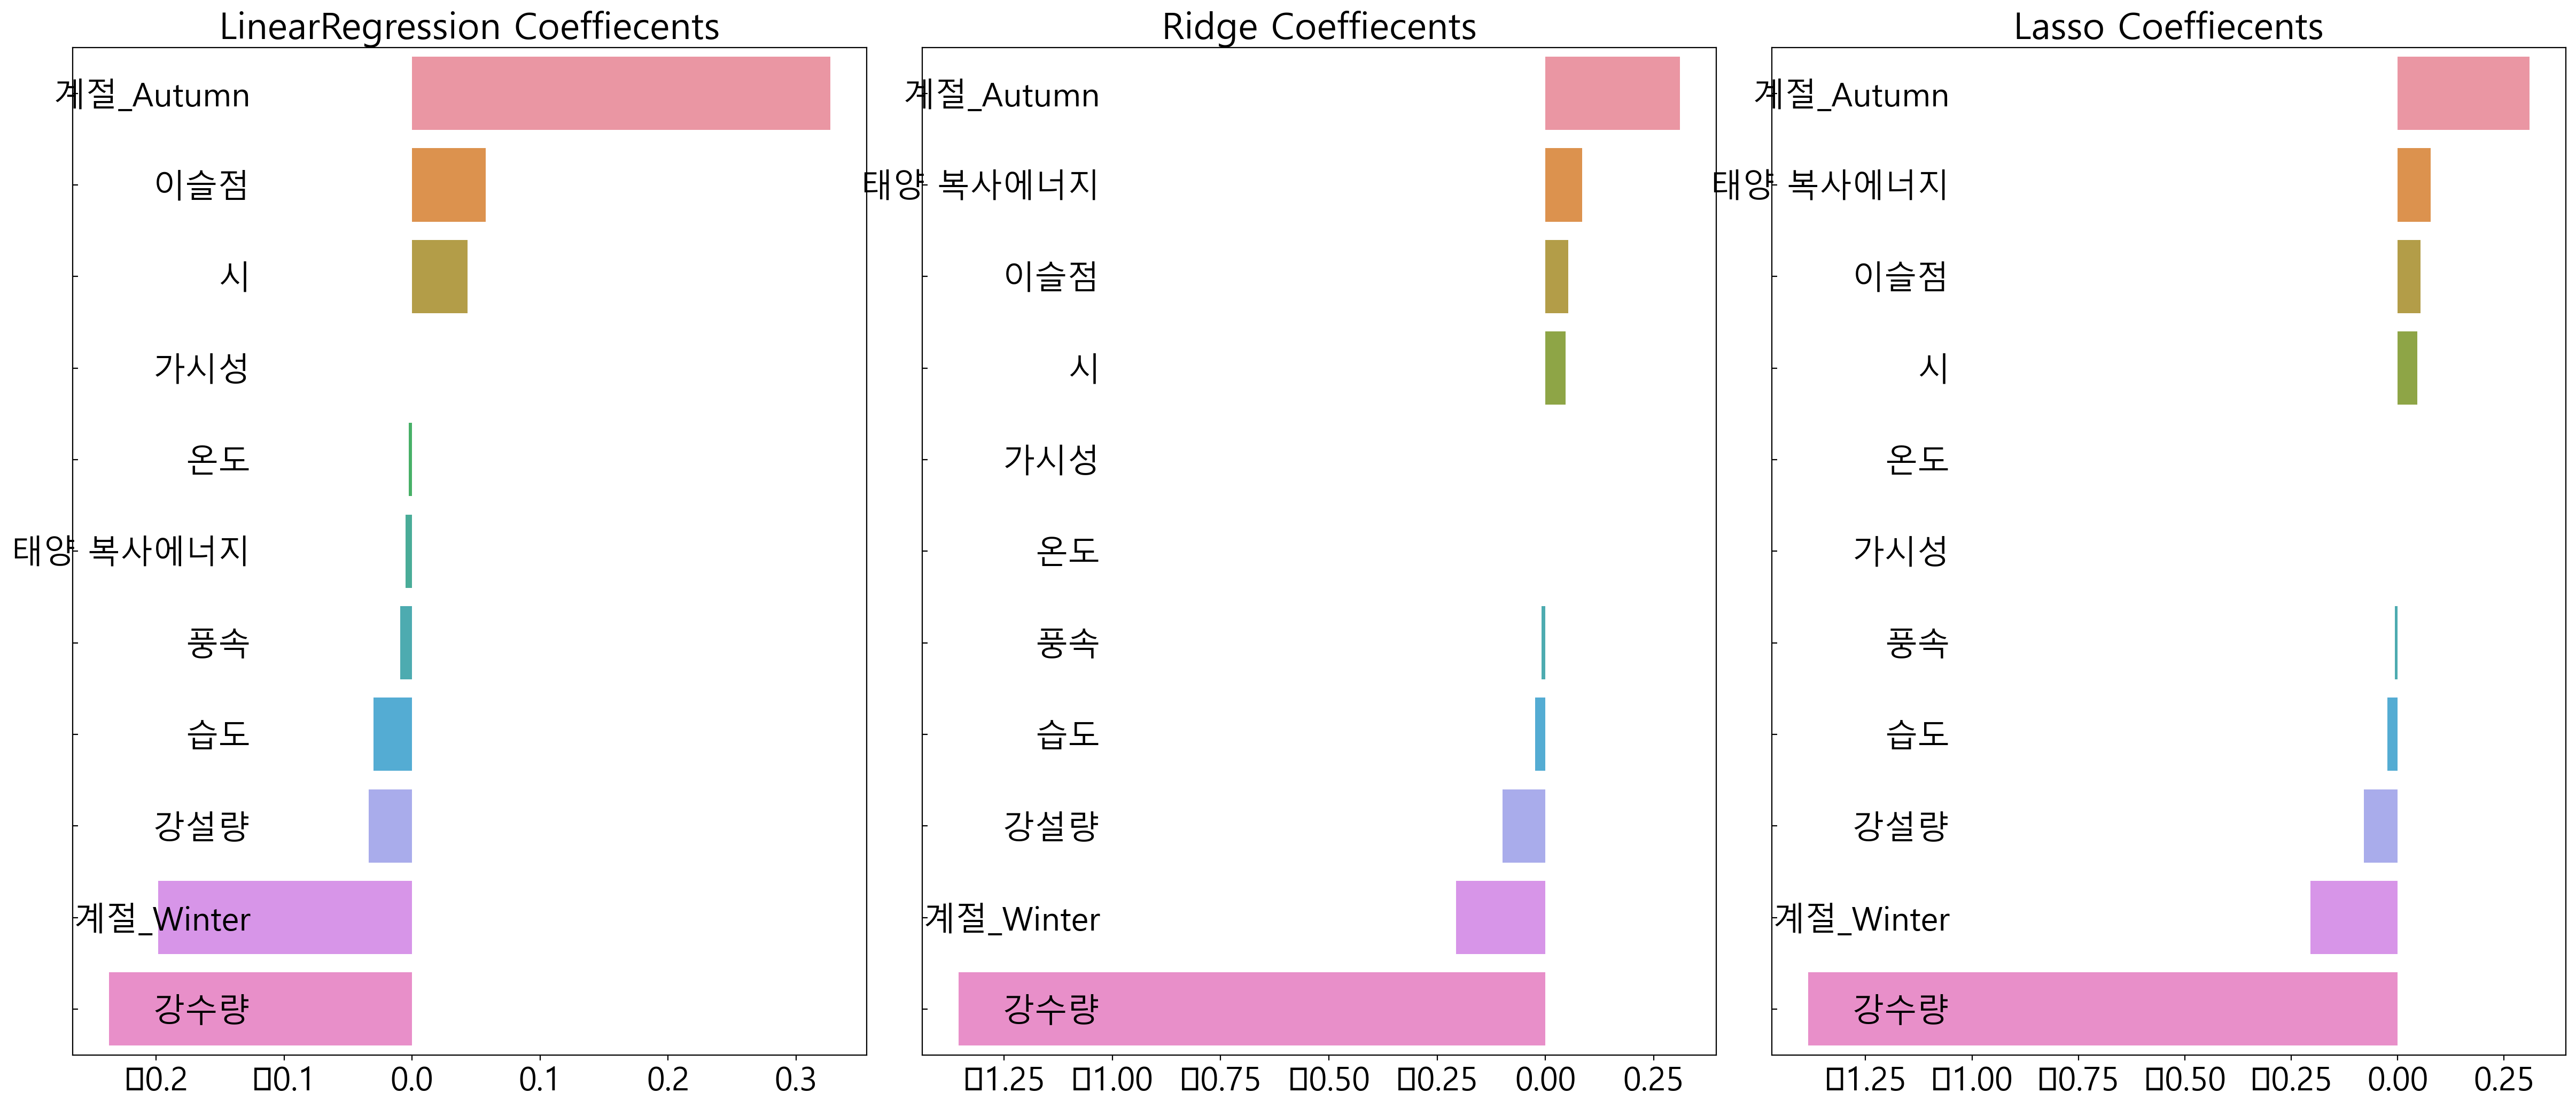

In [351]:
# 최적화 alpha값으로 학습/예측/평가 수행
ridge = Ridge(alpha=15)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])

In [ ]:
# 역시 최적의 alpha값을 넣었을 때 과적합이 일어나서 r제곱이 음수로 나옴 
# linearregression 모델을 사용했을 때가 가장 높은 성능을 지님

### 다항회귀 모델 사용
 - 단순 선형회귀 직선형으로 표현한 것보다 곡선형으로 표현한 것이 더 예측성능이 좋기 때문에 다항회귀도 이용해봄 

,계절_Autumn,계절_Winter,대여횟수,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량
0,0.0,1.0,5.541264,0,-5.2,37,2.200000,2000,-17.6,0.0,0.0,0.0
1,0.0,1.0,5.323010,1,-5.5,38,0.800000,2000,-17.6,0.0,0.0,0.0
2,0.0,1.0,5.159055,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0
3,0.0,1.0,4.682131,3,-6.2,40,0.900000,2000,-17.6,0.0,0.0,0.0
4,0.0,1.0,4.369448,4,-6.0,36,1.599755,2000,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7812,1.0,0.0,7.318540,19,8.4,53,1.904459,2000,-0.6,0.0,0.0,0.0
7813,0.0,1.0,7.070724,20,7.6,59,0.700000,2000,0.0,0.0,0.0,0.0
7814,1.0,0.0,6.975414,21,7.6,59,3.000000,1929,0.0,0.0,0.0,0.0
7815,1.0,0.0,6.993015,22,6.8,58,2.200000,1936,-0.9,0.0,0.0,0.0


,계절_Autumn,계절_Winter,대여횟수,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량
0,0.0,1.0,5.541264,0,-5.2,37,2.200000,2000,-17.6,0.0,0.0,0.0
1,0.0,1.0,5.323010,1,-5.5,38,0.800000,2000,-17.6,0.0,0.0,0.0
2,0.0,1.0,5.159055,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0
3,0.0,1.0,4.682131,3,-6.2,40,0.900000,2000,-17.6,0.0,0.0,0.0
4,0.0,1.0,4.369448,4,-6.0,36,1.599755,2000,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7812,1.0,0.0,7.318540,19,8.4,53,1.904459,2000,-0.6,0.0,0.0,0.0
7813,0.0,1.0,7.070724,20,7.6,59,0.700000,2000,0.0,0.0,0.0,0.0
7814,1.0,0.0,6.975414,21,7.6,59,3.000000,1929,0.0,0.0,0.0,0.0
7815,1.0,0.0,6.993015,22,6.8,58,2.200000,1936,-0.9,0.0,0.0,0.0


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='태양 복사에너지', ylabel='Count'>

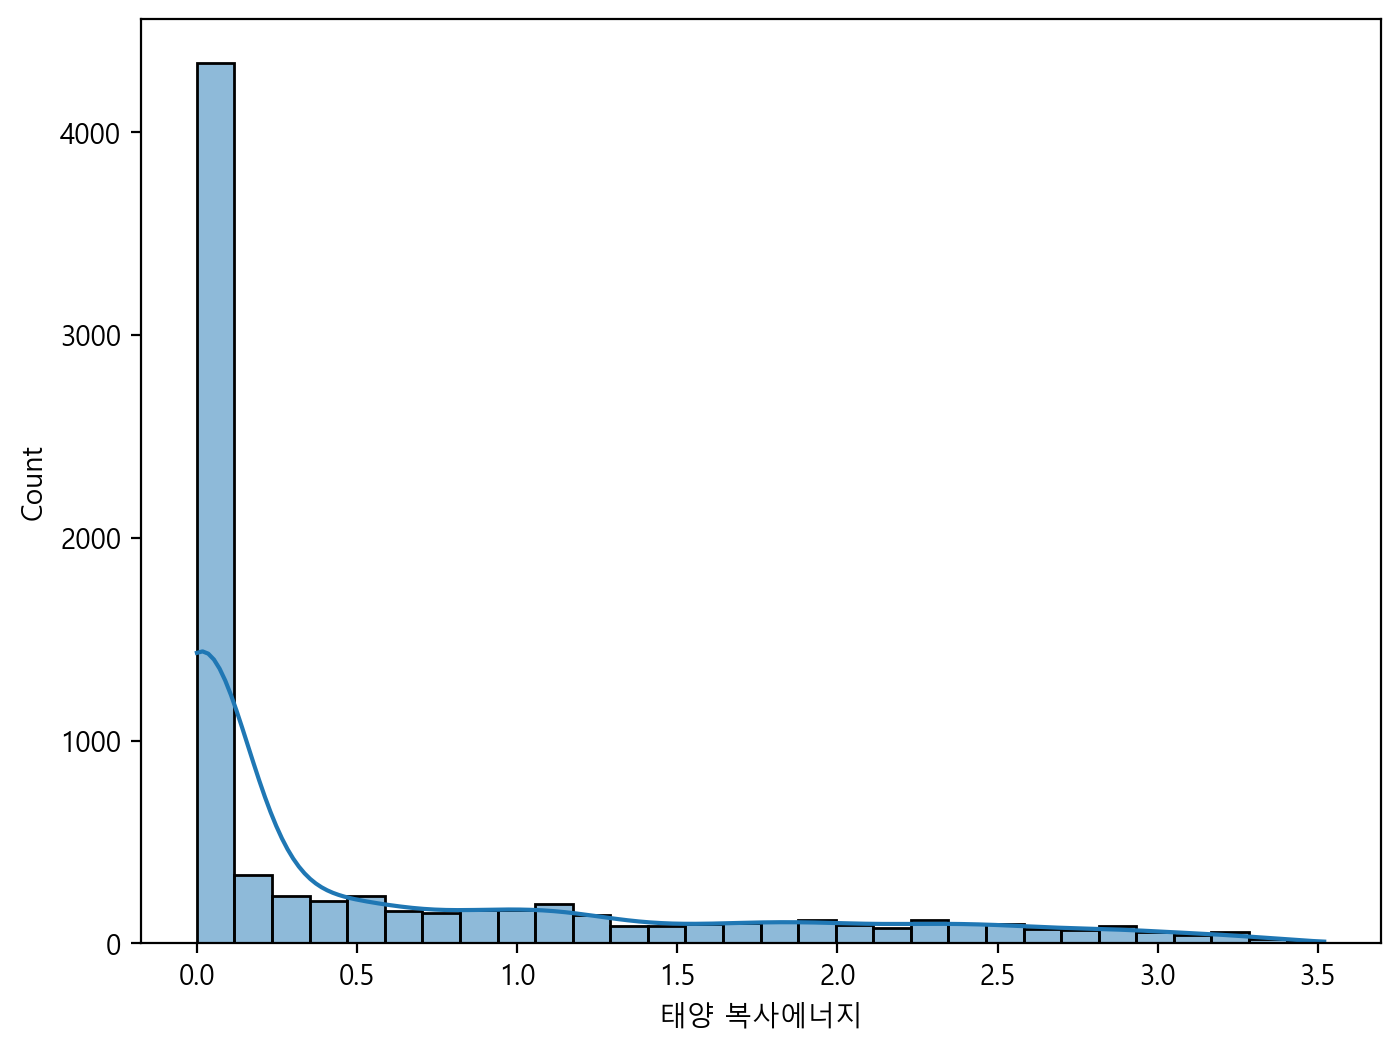

<Axes: xlabel='태양 복사에너지', ylabel='Count'>

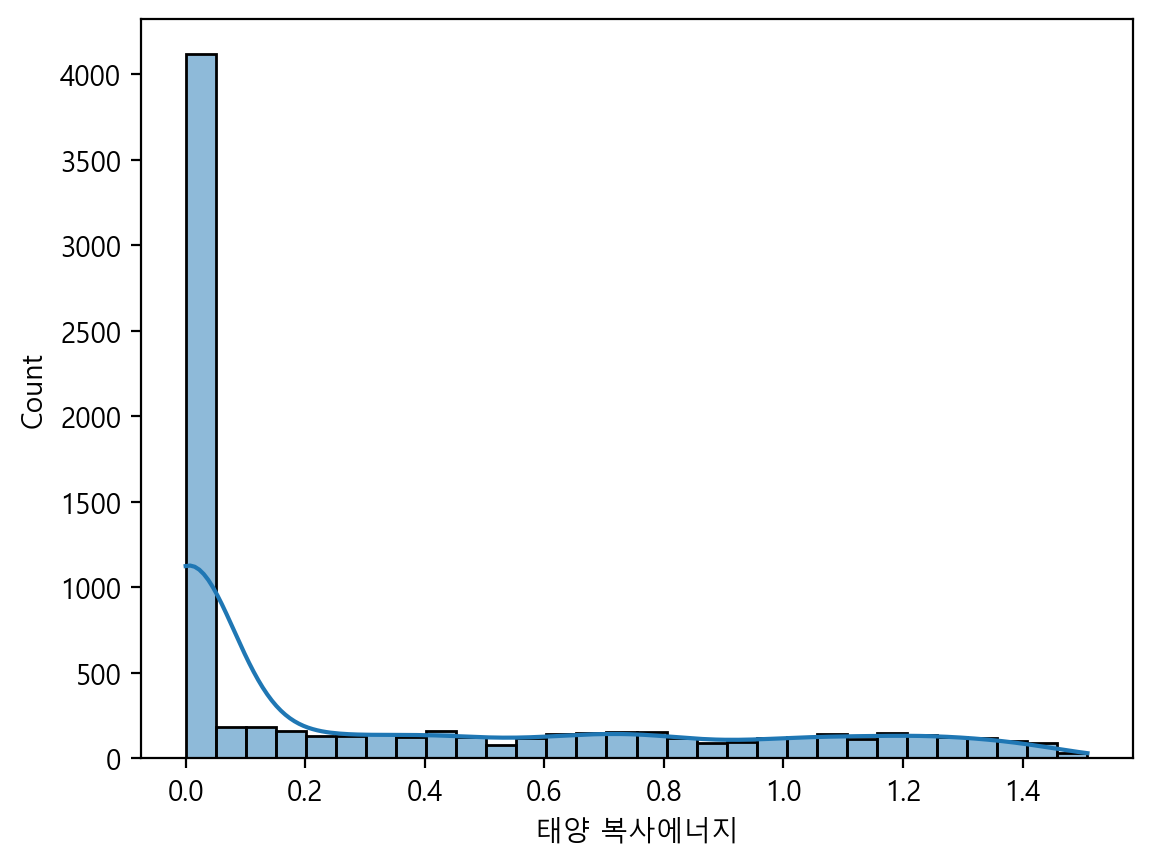

In [348]:
train_a
train_x
plt.figure(figsize=(8, 6))
sns.histplot(train_a['태양 복사에너지'], kde=True, bins=30)
plt.show()
sns.histplot(train_x['태양 복사에너지'], kde=True, bins=30)

In [383]:
# TARGET
y_target = train_x['대여횟수']

# FEATURES
X_data= train_x.drop('대여횟수', axis=1)

In [384]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data ,
                                                       y_target ,
                                                       test_size=0.3, 
                                                       random_state=156)

In [385]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [386]:
# (1) degree=2

# Pipeline으로 수행한 모델 생성
# 'poly' : 첫 번째 스텝 이름 (변수명처럼 임의로 작성)
# 'linear' : 두 번째 스텝 이름

# Pipeline 모델 생성
p_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('linear', LinearRegression())])

# 학습
p_model.fit(X_train, y_train)

# 예측
y_pred = p_model.predict(X_val)

# 평가
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

# 평가지표 출력 
print("MSE : {0:.3F}, RMSE : {1:.3f}".format(mse, rmse))
print("R제곱 : {0:.3F}".format(r2_score(y_val, y_pred)))

Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression())])

MSE : 0.395, RMSE : 0.628
R제곱 : 0.706


In [387]:
# 2) degree=2, include_bias=False

# Pipeline 모델 생성
p2_model = Pipeline([('poly', PolynomialFeatures(degree=2,include_bias=False)),
                    ('linear', LinearRegression())])

# 학습
p2_model.fit(X_train, y_train)

# 예측
y_pred = p2_model.predict(X_val)

# 평가
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

# 평가지표 출력 
print("MSE : {0:.3F}, RMSE : {1:.3f}".format(mse, rmse))
print("R제곱 : {0:.3F}".format(r2_score(y_val, y_pred)))

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('linear', LinearRegression())])

MSE : 0.395, RMSE : 0.628
R제곱 : 0.706


In [388]:
# 2) degree=3, include_bias=False

# Pipeline 모델 생성
p2_model = Pipeline([('poly', PolynomialFeatures(degree=3,include_bias=False)),
                    ('linear', LinearRegression())])

# 학습
p2_model.fit(X_train, y_train)

# 예측
y_pred = p2_model.predict(X_val)

# 평가
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

# 평가지표 출력 
print("MSE : {0:.3F}, RMSE : {1:.3f}".format(mse, rmse))
print("R제곱 : {0:.3F}".format(r2_score(y_val, y_pred)))

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('linear', LinearRegression())])

MSE : 0.315, RMSE : 0.561
R제곱 : 0.766


In [398]:
# 3) degree=3, include_bias=False + ridge

# Pipeline 모델 생성
p_model = Pipeline([('poly', PolynomialFeatures(degree=3,include_bias=False)),
                    ('ridge', Ridge(alpha=0.01))])

# 학습
p_model.fit(X_train, y_train)

# 예측
y_pred = p_model.predict(X_val)

# 평가
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

# 평가지표 출력 
print("MSE : {0:.3F}, RMSE : {1:.3f}".format(mse, rmse))
print("R제곱 : {0:.3F}".format(r2_score(y_val, y_pred)))

# MSE : 0.303, RMSE : 0.551
# R제곱 : 0.774

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=0.01))])

MSE : 0.303, RMSE : 0.550
R제곱 : 0.775


In [390]:
# 2) degree=3, include_bias=False + lasso

# Pipeline 모델 생성
p2_model = Pipeline([('poly', PolynomialFeatures(degree=3,include_bias=False)),
                    ('lasso', Lasso(alpha=0))])

# 학습
p2_model.fit(X_train, y_train)

# 예측
y_pred = p2_model.predict(X_val)

# 평가
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

# 평가지표 출력 
print("MSE : {0:.3F}, RMSE : {1:.3f}".format(mse, rmse))
print("R제곱 : {0:.3F}".format(r2_score(y_val, y_pred)))

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('lasso', Lasso(alpha=0))])

MSE : 0.314, RMSE : 0.560
R제곱 : 0.767


XGBRegressor 최적 평균 RMSE : 0.5583, 최적 alpha {'n_estimators': 1000} 


## 결론 : 다항회귀 모델과 ridge 모델을동시에 사용한 경우 가장 성능이 좋다. 
- 변수 중요도 확인 및 예측

### 변수 중요도

In [400]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators' :[1000]}
xgb_reg = XGBRegressor(objective='reg:squarederror',
                       n_estimators=1000,
                       learning_rate=0.05,
                       colsample_bytree=0.5,
                       subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)


XGBRegressor 최적 평균 RMSE : 0.5583, 최적 alpha {'n_estimators': 1000} 


In [401]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators' :[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,
                        learning_rate=0.05,
                        num_leaves=4,   # 하나의 트리가 가질 수 있는 최대 리프 수
                        colsample_bytree=0.4,
                        subsample=0.6,
                        reg_lambda=10, # L2 규제 적용 값
                        n_jobs=1,
                        force_row_wise=True)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 6253, number of used features: 10
[LightGBM] [Info] Start training from score 6.303302
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 6253, number of used features: 11
[LightGBM] [Info] Start training from score 6.202502
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 6254, number of used features: 11
[LightGBM] [Info] Start training from score 5.981560
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 6254, number of used features: 11
[LightGBM] [Info]

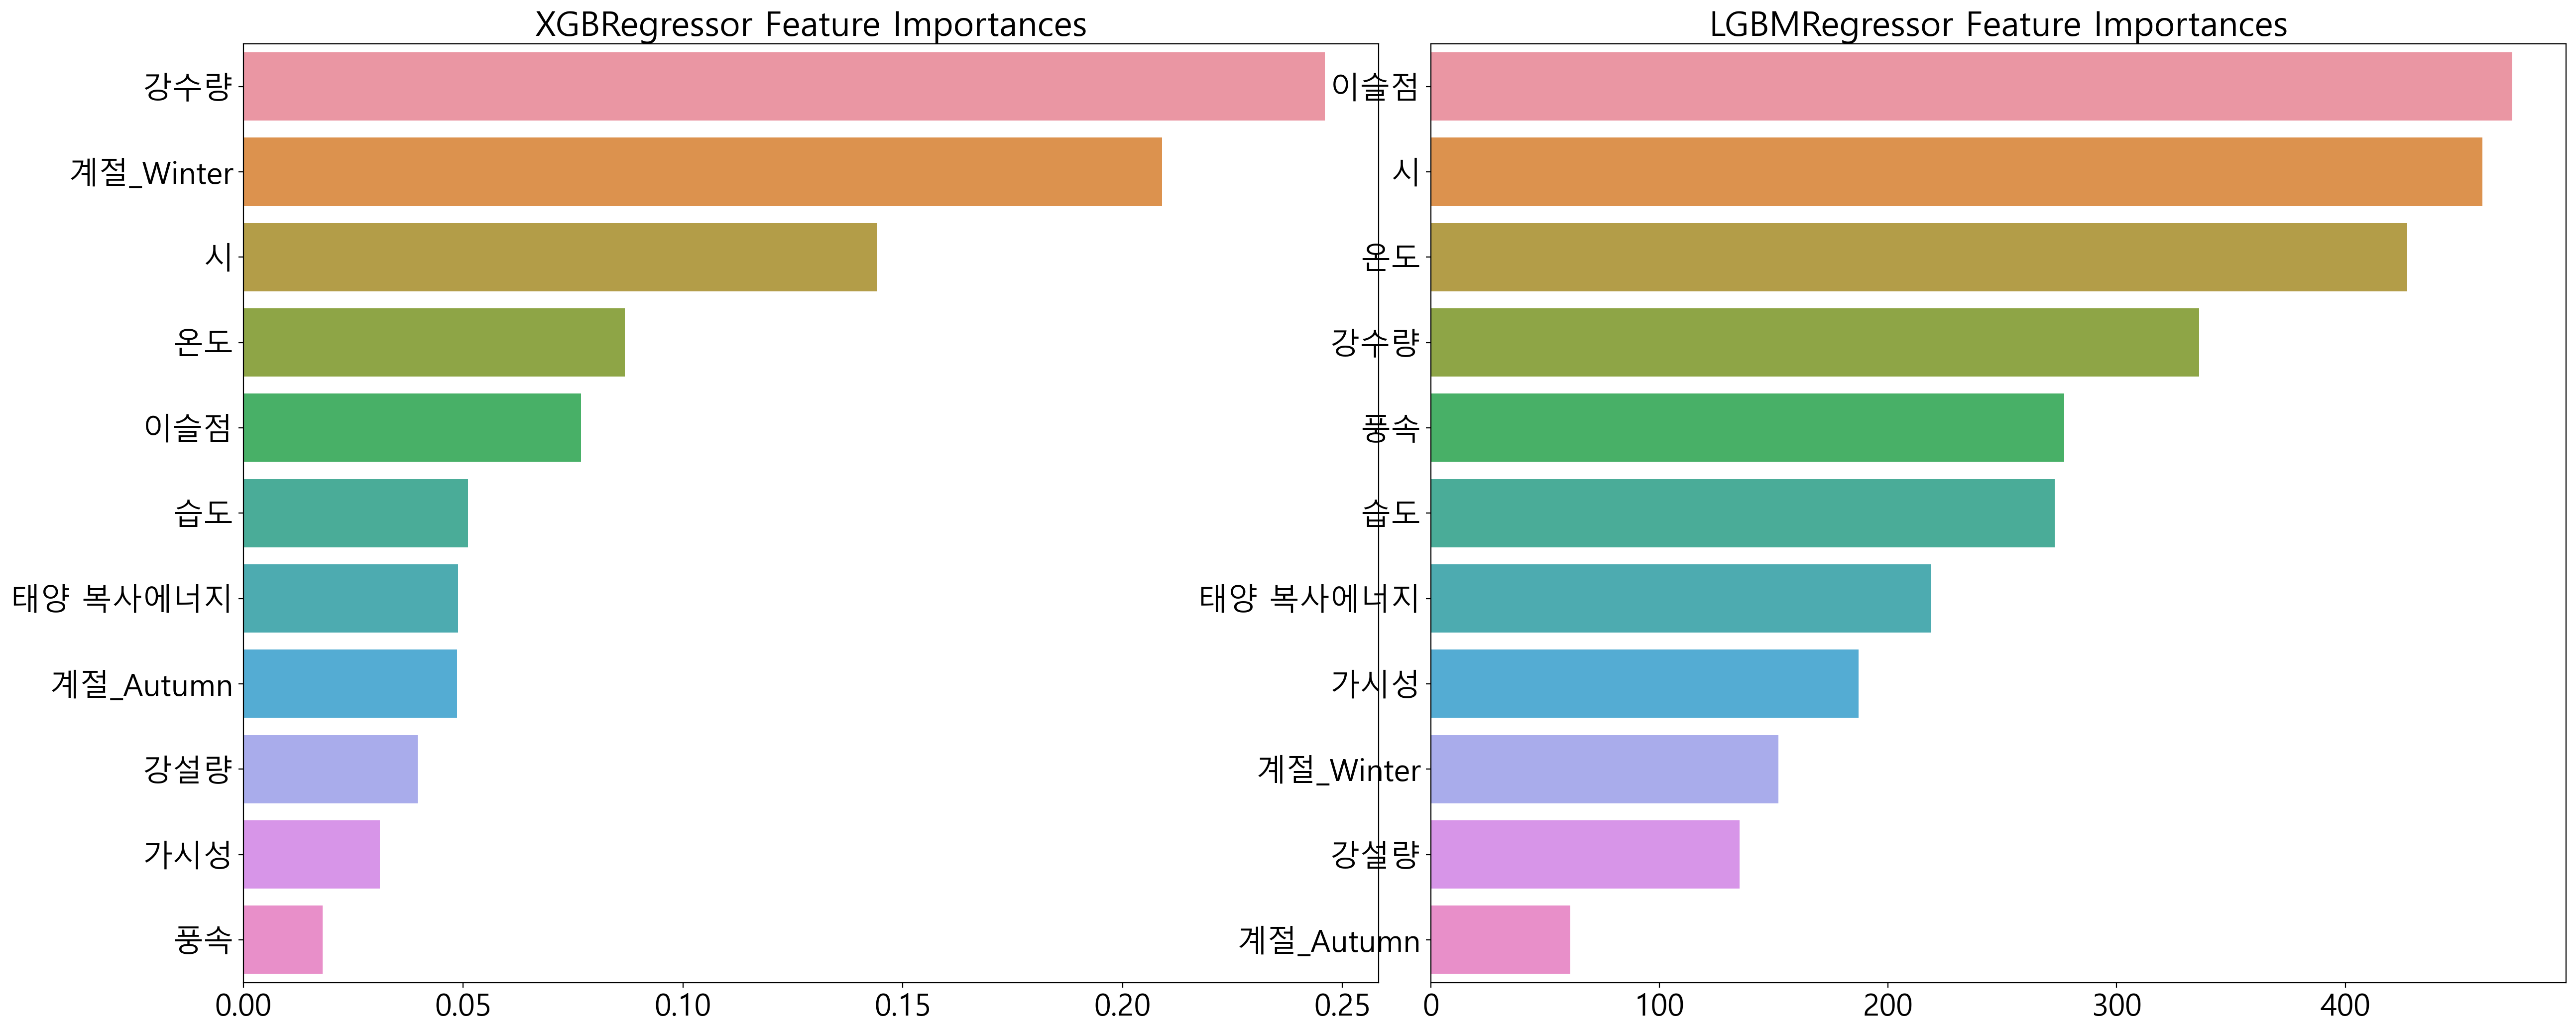

In [403]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_feature.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

visualize_ftr_importances([best_xgb, best_lgbm])

In [409]:
#### 모델 선언

final_model = Pipeline([('poly', PolynomialFeatures(degree=3,include_bias=False)),
                    ('ridge', Ridge(alpha=0.01))])
final_model.fit(X_train, y_train)


Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=0.01))])

In [412]:
a=final_model.predict(test_a)

In [417]:
b=np.exp(a)

In [411]:
train_a['대여횟수']

0       5.541264
1       5.323010
2       5.159055
3       4.682131
4       4.369448
          ...   
7812    7.318540
7813    7.070724
7814    6.975414
7815    6.993015
7816    6.683361
Name: 대여횟수, Length: 7817, dtype: float64

In [418]:
test['대여횟수']= b

In [419]:
test

,계절_Autumn,계절_Winter,휴무일여부_No Holiday,작동여부_No,작동여부_Yes,index,날짜,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,대여횟수
0,1.0,0.0,1.0,0.0,1.0,0,2018-11-01,0,5.7,62,2.300000,1909,-1.0,0.0,0.0,0.0,427.810763
1,1.0,0.0,1.0,0.0,1.0,1,2018-11-01,1,5.1,65,1.600000,1932,-0.9,0.0,0.0,0.0,345.398571
2,1.0,0.0,1.0,0.0,1.0,2,2018-11-01,2,4.4,64,1.043358,2000,-1.8,0.0,0.0,0.0,311.880141
3,1.0,0.0,1.0,0.0,1.0,3,2018-11-01,3,4.2,65,0.700000,1962,-1.8,0.0,0.0,0.0,316.437667
4,1.0,0.0,1.0,0.0,1.0,4,2018-11-01,4,3.6,70,0.800000,1934,-1.3,0.0,0.0,0.0,328.985517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.0,1.0,1.0,0.0,1.0,715,2018-11-30,19,4.2,34,2.600000,1894,-10.3,0.0,0.0,0.0,482.831077
716,1.0,0.0,1.0,0.0,1.0,716,2018-11-30,20,3.4,37,2.300000,2000,-9.9,0.0,0.0,0.0,1355.254573
717,1.0,0.0,1.0,0.0,1.0,717,2018-11-30,21,2.6,39,0.300000,1968,-9.9,0.0,0.0,0.0,1785.878908
718,1.0,0.0,1.0,0.0,1.0,718,2018-11-30,22,2.1,41,1.000000,1859,-9.8,0.0,0.0,0.0,1306.218288


In [420]:
test.to_csv('test_예측완료.csv', index = False)